# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [4]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [5]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [6]:
import gym
import numpy as np
import time
from IPython.display import clear_output
import seaborn as sns


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [7]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    predict = Q[state, action]
    target = reward if done else reward + gamma * np.max(Q[state2, :])
    Q[state, action] = predict + lr_rate * (target - predict)

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




Вывод ответов при заданных параметрах

In [8]:
from tqdm import tqdm

np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Счетчики побед
total_wins = 0
consecutive_wins = 0
first_5_wins_game = None

for game in tqdm(range(1, total_games + 1)):
    state = env.reset()
    t = 0
    done = False

    while t < max_steps:
        t += 1

        action = choose_action(state)
        state2, reward, done, info = env.step(action)

        learn(state, state2, reward, action, done)
        state = state2

        if done:
            break

    if reward == 1.0:
        total_wins += 1
        consecutive_wins += 1
        if consecutive_wins == 5 and first_5_wins_game is None:
            first_5_wins_game = game
    else:
        consecutive_wins = 0



100%|██████████| 10000/10000 [00:14<00:00, 684.04it/s]


In [9]:
print(f"Общее количество побед в серии из 10000 игр: {total_wins}")
if first_5_wins_game:
    print(f"Агент впервые одержал 5 побед подряд на игре: {first_5_wins_game}")
else:
    print("Агент ни разу не победил 5 раз подряд.")

Общее количество побед в серии из 10000 игр: 7914
Агент впервые одержал 5 побед подряд на игре: 885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [10]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

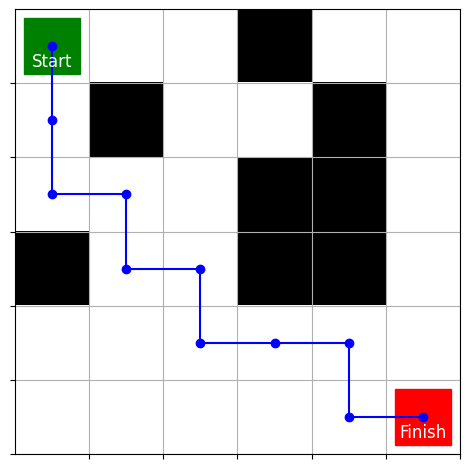

In [11]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

In [12]:
from tqdm import tqdm
import numpy as np

np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

total_wins = 0
consecutive_wins = 0
first_5_wins_game = None

# SARSA версия функции обучения
def learn(state, state2, reward, action, action2, done):
    predict = Q[state, action]
    target = reward if done else reward + gamma * Q[state2, action2]
    Q[state, action] = predict + lr_rate * (target - predict)

for game in tqdm(range(1, total_games + 1)):
    state = env.reset()
    action = choose_action(state)
    t = 0
    done = False

    while t < max_steps:
        t += 1

        state2, reward, done, info = env.step(action)
        action2 = choose_action(state2)

        learn(state, state2, reward, action, action2, done)

        state = state2
        action = action2

        if done:
            break

    # Учёт побед
    if reward == 1.0:
        total_wins += 1
        consecutive_wins += 1
        if consecutive_wins == 5 and first_5_wins_game is None:
            first_5_wins_game = game
    else:
        consecutive_wins = 0

# Итог

print(f"\nОбщее количество побед: {total_wins}")
if first_5_wins_game:
    print(f"Агент впервые одержал 5 побед подряд на игре номер: {first_5_wins_game}")
else:
    print("Агент ни разу не победил 5 раз подряд.")

100%|██████████| 40000/40000 [00:38<00:00, 1038.16it/s]


Общее количество побед: 32328
Агент впервые одержал 5 побед подряд на игре номер: 894


## Графики (Анализ гиперпараметров)

In [13]:
wins = []
for lr_rate in [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]:
    total_games = 10000
    max_steps = 100
    total_wins = 0
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        t = 0
        done = False

        while t < max_steps:
            t += 1

            action = choose_action(state)
            state2, reward, done, info = env.step(action)

            predict = Q[state, action]
            target = reward if done else reward + gamma * np.max(Q[state2, :])
            Q[state, action] = predict + lr_rate * (target - predict)
            state = state2

            if done:
                break

        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 10000/10000 [00:07<00:00, 1295.01it/s]


In [14]:
wins

[6960, 6769, 7042, 6667, 7259, 7525, 7898]

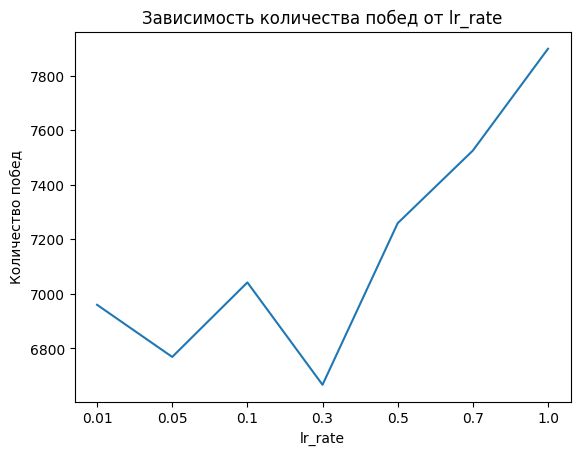

In [15]:
sns.lineplot(wins)
plt.xlabel("lr_rate")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от lr_rate")
plt.xticks(range(len(wins)), [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
plt.show()

In [16]:
wins = []
for gamma in [0.0, 0.2, 0.4, 0.6, 0.8, 0.99]:
    total_games = 10000
    max_steps = 100
    total_wins = 0
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        t = 0
        done = False

        while t < max_steps:
            t += 1

            action = choose_action(state)
            state2, reward, done, info = env.step(action)

            predict = Q[state, action]
            target = reward if done else reward + gamma * np.max(Q[state2, :])
            Q[state, action] = predict + lr_rate * (target - predict)
            state = state2

            if done:
                break

        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 10000/10000 [00:07<00:00, 1339.67it/s]


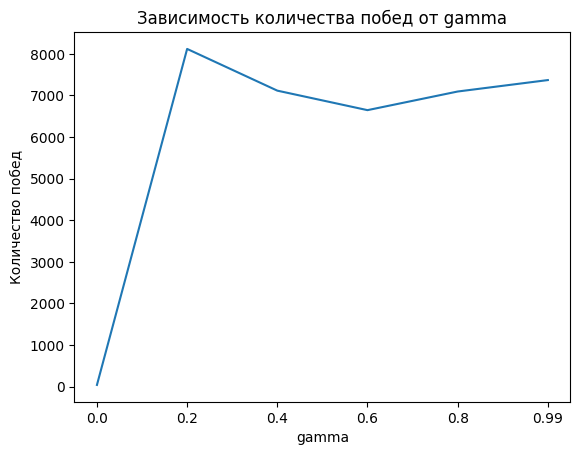

In [17]:
sns.lineplot(wins)
plt.xlabel("gamma")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от gamma")
plt.xticks(range(len(wins)), [0.0,  0.2, 0.4, 0.6, 0.8, 0.99])
plt.show()

In [18]:
def choose_action(state, epsilon):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action


In [19]:
wins = []
for epsilon in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    total_games = 10000
    max_steps = 100
    total_wins = 0
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        t = 0
        done = False

        while t < max_steps:
            t += 1

            action = choose_action(state, epsilon)
            state2, reward, done, info = env.step(action)

            predict = Q[state, action]
            target = reward if done else reward + gamma * np.max(Q[state2, :])
            Q[state, action] = predict + lr_rate * (target - predict)
            state = state2

            if done:
                break

        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 10000/10000 [00:02<00:00, 3415.31it/s]


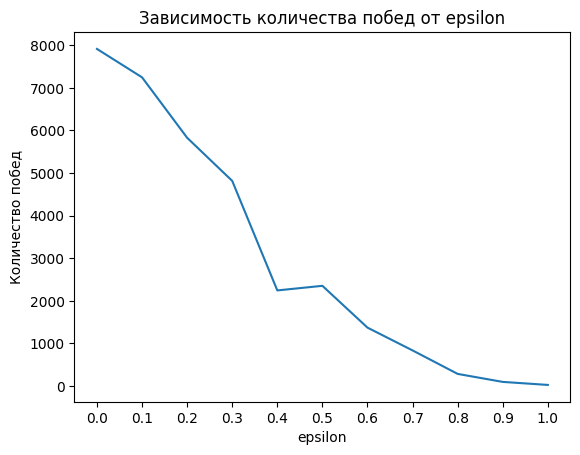

In [20]:
sns.lineplot(wins)
plt.xlabel("epsilon")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от epsilon")
plt.xticks(range(len(wins)), [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

## SARSA визуализации

In [21]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

In [22]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

In [23]:
wins = []
for lr_rate in [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]:
    total_wins = 0
    total_games = 40000
    max_steps = 100
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        action = choose_action(state)
        t = 0
        done = False

        while t < max_steps:
            t += 1

            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2)

            predict = Q[state, action]
            target = reward if done else reward + gamma * Q[state2, action2]
            Q[state, action] = predict + lr_rate * (target - predict)

            state = state2
            action = action2

            if done:
                break

    # Учёт побед
        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 40000/40000 [00:26<00:00, 1517.18it/s]


In [24]:
wins

[31803, 33810, 34136, 33858, 33455, 33424, 4560]

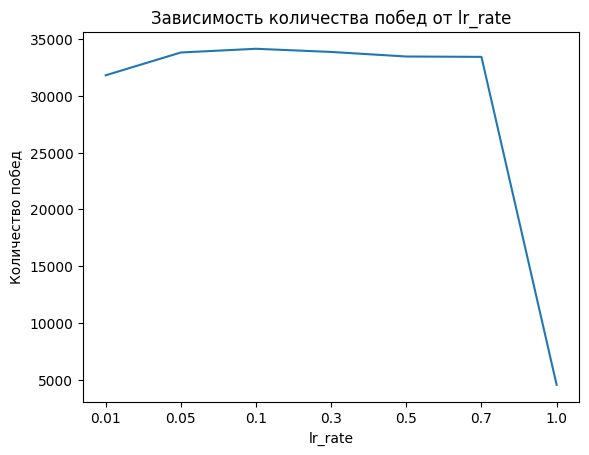

In [25]:
sns.lineplot(wins)
plt.xlabel("lr_rate")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от lr_rate")
plt.xticks(range(len(wins)), [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
plt.show()

In [26]:
wins = []
for gamma in [0.0, 0.2, 0.4, 0.6, 0.8, 0.99]:
    total_wins = 0
    total_games = 40000
    max_steps = 100
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        action = choose_action(state)
        t = 0
        done = False

        while t < max_steps:
            t += 1

            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2)

            predict = Q[state, action]
            target = reward if done else reward + gamma * Q[state2, action2]
            Q[state, action] = predict + lr_rate * (target - predict)

            state = state2
            action = action2

            if done:
                break

    # Учёт побед
        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 40000/40000 [00:27<00:00, 1449.50it/s]


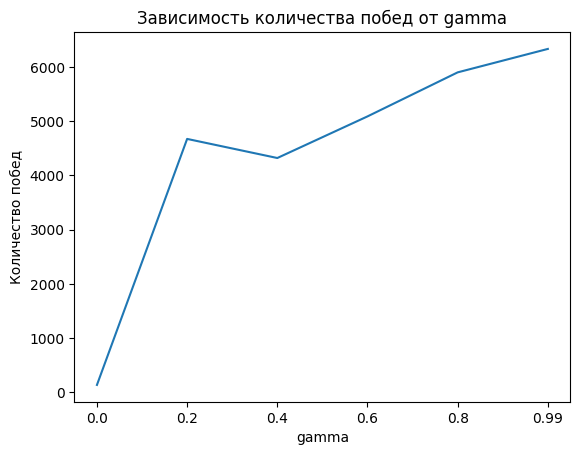

In [27]:
sns.lineplot(wins)
plt.xlabel("gamma")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от gamma")
plt.xticks(range(len(wins)), [0.0,  0.2, 0.4, 0.6, 0.8, 0.99])
plt.show()

In [28]:
def choose_action(state, epsilon):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

In [29]:
wins = []
for epsilon in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    total_wins = 0
    total_games = 40000
    max_steps = 100
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for game in tqdm(range(1, total_games + 1)):
        state = env.reset()
        action = choose_action(state, epsilon)
        t = 0
        done = False

        while t < max_steps:
            t += 1

            state2, reward, done, info = env.step(action)
            action2 = choose_action(state2, epsilon)

            predict = Q[state, action]
            target = reward if done else reward + gamma * Q[state2, action2]
            Q[state, action] = predict + lr_rate * (target - predict)

            state = state2
            action = action2

            if done:
                break

    # Учёт побед
        if reward == 1.0:
            total_wins += 1
    wins.append(total_wins)

100%|██████████| 40000/40000 [00:09<00:00, 4303.00it/s]


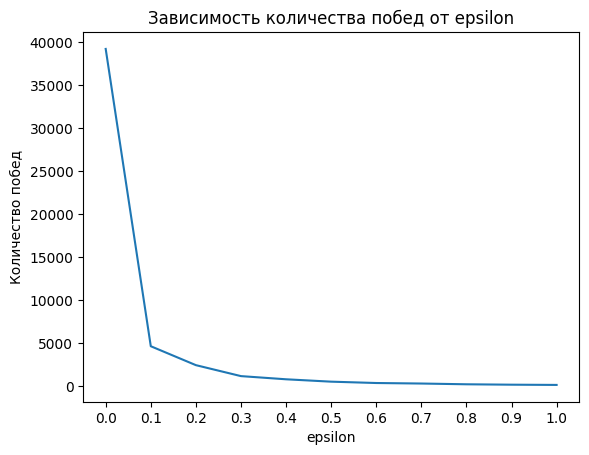

In [30]:
sns.lineplot(wins)
plt.xlabel("epsilon")
plt.ylabel("Количество побед")
plt.title("Зависимость количества побед от epsilon")
plt.xticks(range(len(wins)), [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()